In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers datasets evaluate seqeval --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 25.2 MB/s eta 0:

In [ ]:
import os
import ast
import json
import yaml
import shutil
import pickle
import pandas as pd
import numpy as np
import itertools
from pathlib import Path
from tqdm.auto import tqdm
from functools import reduce
from typing import Literal
from collections import Counter, OrderedDict

In [ ]:
import spacy
import gc
from datetime import datetime
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.nn import CrossEntropyLoss, MSELoss

import datasets
from datasets import Dataset, Features, Sequence, Value, ClassLabel

from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple, Union

from transformers.modeling_utils import PreTrainedModel, unwrap_model

# from transformers import AdamW

from transformers import AutoTokenizer, AutoModel

from transformers import AutoModelForTokenClassification, AutoTokenizer

from transformers.models.xlm_roberta.configuration_xlm_roberta import XLMRobertaConfig

from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_utils import PreTrainedModel

from transformers.models.xlm_roberta.modeling_xlm_roberta import (
    XLMRobertaPreTrainedModel,
    XLMRobertaModel,
    XLMRobertaEmbeddings
)

from transformers.modeling_outputs import (
    BaseModelOutput,
    TokenClassifierOutput
)

from torch.utils.data import DataLoader, TensorDataset
from dataclasses import dataclass

from evaluate import load

seqeval = load("seqeval") # load seqeval metric 
nlp = spacy.load('en_core_web_sm') # load en_core_web_sm model 
tqdm.pandas()

In [ ]:
def load_config(path_to_yaml_file: str):
    """
    load the configuration file as .yaml
    """
    with open(path_to_yaml_file, "r") as stream:
        try:
            data = yaml.safe_load(stream)
            print("loaded config.yaml successfully!")
        except yaml.YAMLError as exc:
            print(exc)
            data = None
    return data

PATH_TO_CONFIG_FILE = "./drive/MyDrive/legal_NER/config.yaml"
config_data = load_config(PATH_TO_CONFIG_FILE)

loaded config.yaml successfully!


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# ------------------------------------------------- XLMRobertaCRFforTokenClassification ------------------------------------------------- # 

In [ ]:
@dataclass
class TokenCRFClassifierOutput(TokenClassifierOutput):
    loss: Optional[torch.FloatTensor] = None
    prediction_scores: torch.FloatTensor = None
    predictions: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

In [ ]:
class XLMRobertaCRFforTokenClassification(XLMRobertaPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"Pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.roberta = XLMRobertaModel(config, add_pooling_layer=False)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.crf = LC_CRF(nb_labels=config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        mask: Optional[torch.Tensor] = None, # new addition of mask 
        reduction: Optional[torch.Tensor] = "none", # new addition of reduction
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], TokenClassifierOutput]:

        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the token classification loss. Indices should be in `[0, ..., config.num_labels - 1]`.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        prediction_scores = None
        predictions = None
        if labels is not None:
            # loss_fct = CrossEntropyLoss(weight=self.ce_weights)
            # loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            loss = self.crf(emissions=logits,
                            tags=labels,
                            mask=mask,
                            reduction=reduction)
        else:
            with torch.no_grad():
                prediction_scores, predictions = self.crf.decode(emissions=logits)
            
        if not return_dict:
            output = (logits,) + outputs[2:]
            output =  ((loss,) + output) if loss is not None else output # append loss if not none

        return TokenCRFClassifierOutput(
            loss=loss,
            logits=logits,
            predictions=predictions,
            prediction_scores=prediction_scores,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )            

In [ ]:
class LC_CRF(nn.Module):
    """
    Linear-chain Conditional Random Field (CRF)

    Args:
        nb_labels (int): number of labels in tagset, including special symbols (below).
        bos_tag_id (int): integer representing the beginning of sentence symbol in
            your tagset.
        eos_tag_id (int): integer representing the end of sentence symbol in your tagset.
        pad_tag_id (int, optional): integer representing the pad symbol in your tagset.
            If None, the model will treat the PAD as a normal tag. Otherwise, the model
            will apply constraints for PAD transitions.
    """
    def __init__(self, nb_labels, device="cuda" if torch.cuda.is_available() else "cpu"):
        super(LC_CRF, self).__init__()

        self.nb_labels = nb_labels

        self.DEVICE = device

        self.start_transitions = nn.Parameter(torch.empty(self.nb_labels))
        self.end_transitions = nn.Parameter(torch.empty(self.nb_labels))
        self.transitions = nn.Parameter(torch.empty(self.nb_labels, self.nb_labels))
        self.init_weights()

    def init_weights(self):
        nn.init.uniform_(self.start_transitions, -0.1, 0.1)
        nn.init.uniform_(self.end_transitions, -0.1, 0.1)
        nn.init.uniform_(self.transitions, -0.1, 0.1)

    def forward(self, emissions, tags, mask=None, reduction: str='sum'):
        """
        Compute the negative log-likelihood.
        """
        return -self.log_likelihood(emissions, tags, mask=mask, reduction=reduction)

    def log_likelihood(self, emissions, tags, mask=None, reduction: str='sum'):
        """
        Compute the probability of sequence of tags given a sequence of emission 
        scores.

        Args:
            emissions (torch.Tensor): Sequence of emissions for each label. 
                Shape (batch_size, seq_len, nb_labels)
            tags (torch.LongTensor): Sequence of labels.
                Shape (batch_size, seq_len)
            mask (torch.FloatTensor, optional): Tensor representing valid positions.
                If None, all positions are considered valid.
                Shape (batch_size, seq_len)
            reduction: Specifies  the reduction to apply to the output:
                ``none|sum|mean|token_mean``. ``none``: no reduction will be applied.
                ``sum``: the output will be summed over batches. ``mean``: the output will be
                averaged over batches. ``token_mean``: the output will be averaged over tokens.

        Returns:
            torch.Tensor: the (summed) log-likelihoods of each sequence in the batch.
                Shape of (1,)
        """   
        if mask is None:
            mask = torch.ones(emissions.shape[:2], dtype=torch.float)

        scores = self._compute_scores(emissions, tags, mask=mask)
        partition = self._compute_log_partition(emissions, mask=mask)
        llh = scores - partition

        if reduction == 'none':
            return llh
        if reduction == 'sum':
            return llh.sum()
        if reduction == 'mean':
            return llh.mean()
        assert reduction == 'token_mean'
        return llh.sum() / mask.sum()

    def _compute_scores(self, emissions, tags, mask):
        """
        Compute the scores for a given batch of emissions with their tags.

        Args:
            emissions (torch.Tensor): 
                Shape (batch_size, seq_len, nb_labels)
            tags (Torch.LongTensor): 
                Shape (batch_size, seq_len)
            mask (Torch.FloatTensor): 
                Shape (batch_size, seq_len)

        Returns:
            torch.Tensor: Scores for each batch
                Shape (batch_size,)
        """
        batch_size, seq_length = tags.shape
        scores = torch.zeros(batch_size).to(self.DEVICE)

        # save first and last tags to be used later
        first_tags = tags[:, 0]
        last_valid_idx = mask.int().sum(1) - 1
        last_tags = tags.gather(1, last_valid_idx.unsqueeze(1)).squeeze()

        # add the transition from BOS to the first tags for each batch
        t_scores = self.start_transitions[first_tags]

        # add the [unary] emission scores for the first tags for each batch
        # for all batches, the first word, see the correspondent emissions
        # for the first tags (which is a list of ids):
        # emissions[:, 0, [tag_1, tag_2, ..., tag_nblabels]]
        e_scores = emissions[:, 0].gather(1, first_tags.unsqueeze(1)).squeeze()

        # the scores for a word is just the sum of both scores
        scores += e_scores + t_scores

        # now lets do this for each remaining word
        for i in range(1, seq_length):

            # we could: iterate over batches, check if we reached a mask symbol
            # and stop the iteration, but vecotrizing is faster due to gpu,
            # so instead we perform an element-wise multiplication
            is_valid = mask[:, i]

            previous_tags = tags[:, i - 1]
            current_tags = tags[:, i]

            # calculate emission and transition scores as we did before
            e_scores = emissions[:, i].gather(1, current_tags.unsqueeze(1)).squeeze()
            t_scores = self.transitions[previous_tags, current_tags]

            # apply the mask
            e_scores = e_scores * is_valid
            t_scores = t_scores * is_valid

            scores += e_scores + t_scores

        # add the transition from the end tag to the EOS tag for each batch
        scores += self.end_transitions[last_tags]

        return scores
        
    def _compute_log_partition(self, emissions, mask):
        """
        Compute the partition function in log-space using the forward-algorithm.

        Args:
            emissions (torch.Tensor): 
                Shape (batch_size, seq_len, nb_labels)
            mask (Torch.FloatTensor): 
                Shape (batch_size, seq_len)

        Returns:
            torch.Tensor: the partition scores for each batch.
                Shape (batch_size,)
        """
        batch_size, seq_length, nb_labels = emissions.shape

        # in the first iteration, BOS will have all the scores
        alphas = self.start_transitions + emissions[:, 0]

        for i in range(1, seq_length):
            alpha_t = []

            for tag in range(nb_labels):

                # get the emission for the current tag
                e_scores = emissions[:, i, tag]

                # broadcast emission to all labels
                # since it will be the same for all previous tags
                # (bs, nb_labels)
                e_scores = e_scores.unsqueeze(1)

                # transitions from something to our tag
                t_scores = self.transitions[:, tag]

                # broadcast the transition scores to all batches
                # (bs, nb_labels)
                t_scores = t_scores.unsqueeze(0)

                # combine current scores with previous alphas
                # since alphas are in log space (see logsumexp below),
                # we add them instead of multiplying
                scores = e_scores + t_scores + alphas

                # add the new alphas for the current tag
                alpha_t.append(torch.logsumexp(scores, dim=1))

            # create a torch matrix from alpha_t
            # (bs, nb_labels)
            new_alphas = torch.stack(alpha_t).t()

            # set alphas if the mask is valid, otherwise keep the current values
            is_valid = mask[:, i].unsqueeze(-1)
            alphas = is_valid * new_alphas + (1 - is_valid) * alphas

        # add the scores for the final transition
        last_transition = self.end_transitions
        end_scores = alphas + last_transition.unsqueeze(0)

        # return a *log* of sums of exps
        return torch.logsumexp(end_scores, dim=1)

    def decode(self, emissions, mask=None):
        """
        Find the most probable sequence of labels given the emissions using
        the Viterbi algorithm.

        Args:
            emissions (torch.Tensor): Sequence of emissions for each label.
                Shape (batch_size, seq_len, nb_labels) 
            mask (torch.FloatTensor, optional): Tensor representing valid positions.
            If None, all positions are considered valid.
                Shape (batch_size, seq_len)
        
        Returns:
            torch.Tensor: the Vertibi score for each sequence in the batch
                Shape (batch_size,)
            list of lists: the best vertibi sequence of labels for each batch.
        """
        if mask is None:
            mask = torch.ones(emissions.shape[:2], dtype=torch.float).to(DEVICE)

        scores, sequences = self._vertibi_decode(emissions, mask)
        
        if all([True if len(sequence) == emissions.shape[1] else False for sequence in sequences]):
            return torch.tensor(scores), torch.tensor(sequences)
        
        return scores, sequences

    def _vertibi_decode(self, emissions, mask):
        """
        Compute the vertibi algorithm to find the most probable sequence of labels
        given a sequence of emissions.

        Args:  
            emissions (torch.Tensor): (batch_size, seq_len, nb_labels)
            mask (torch.Tensor): (batch_size, seq_len)

        Returns:
            torch.Tensor: the vertibi score for each sequence in the batch
                Shape (batch_size,)
            list of lists: the best vertibi sequence of labels for each batch.
        """
        batch_size, seq_length, nb_labels = emissions.shape

        # in the first iteration, BOS will have all the scores and then, the max
        alphas = self.start_transitions + emissions[:, 0]

        backpointers = []
        
        for i in range(1, seq_length):
            alpha_t = []
            backpointers_t = []

            for tag in range(nb_labels):

                # get the emissions for the current tag and broadcast to all labels
                e_scores = emissions[:, i, tag]
                e_scores = e_scores.unsqueeze(1)

                # transitions from something to our tag and boradcast to all batches
                t_scores = self.transitions[:, tag]
                t_scores = t_scores.unsqueeze(0)

                # combine current scores with previous alphas
                scores = e_scores + t_scores + alphas

                # so far is exactly like the forward algorithm
                # but now, instead of calculating the logsumexp
                # we will find the highest score and the tag associated with it
                max_score, max_score_tag = torch.max(scores, dim=-1)

                # add the max score for the current tag
                alpha_t.append(max_score)

                # add the max_score for our list of backpointers
                backpointers_t.append(max_score_tag)

            # create a torch matrix from alpha_t
            # (batch_size, nb_labels)
            new_alphas = torch.stack(alpha_t).t()

            # set alphas if the mask is valid, otherwise keep the current values
            is_valid = mask[:, i].unsqueeze(-1)
            alphas = is_valid * new_alphas + (1 - is_valid) * alphas

            # append the new backpointers
            backpointers.append(backpointers_t)

        # add the scores for the final transition
        last_transition = self.end_transitions
        end_scores = alphas + last_transition.unsqueeze(0)

        # get the final most probable score and the final most probable tag
        max_final_scores, max_final_tags = torch.max(end_scores, dim=1)

        # find the best sequence of labels for each sample in the batch
        best_sequences = []
        emission_lengths = mask.int().sum(dim=1)
        
        for i in range(batch_size):

            # recover the original sentence length for the i-th sample in the batch
            sample_length = emission_lengths[i].item()

            # recover the max tag for the last timestep
            sample_final_tag = max_final_tags[i].item()

            # limit the backpointers until the last but one
            # since the last corresponds to the sample_final_tag
            sample_backpointers = backpointers[: sample_length - 1]

            # follow the backpointers to build the sequence of labels
            sample_path = self._find_best_path(i, sample_final_tag, sample_backpointers)

            # add this path to the list of best sequences
            best_sequences.append(sample_path)

        return max_final_scores, best_sequences

    def _find_best_path(self, sample_id, best_tag, backpointers):
        """
        Auxiliary function to find the best path sequence for a specific sample.

        Args:
            sample_id (int): sample index in the range [0, batch_size)

            best_tag (int): tag which maximizes the final score

            backpointers (list of lists of tensors): list of pointers with
                Shape (seq_len_i-1, nb_labels, batch_size);
                where seq_len_i represents the length of the ith sample in the batch

        Returns:
            list of ints: a list of tag indexes representing the bast path
        """
        # add the final best_tag to our best path
        best_path = [best_tag]

        # traverse the backpointers in backwards
        for backpointers_t in reversed(backpointers):

            # recover the best_tag at this timestep
            best_tag = backpointers_t[best_tag][sample_id].item()

            # append to the beginning of the list so we don't need to reverse it later
            best_path.insert(0, best_tag)

        return best_path

In [ ]:
# ------------------------------------------------- XLMRobertaforTokenClassification ------------------------------------------------- # 

In [ ]:
class XLMRobertaforTokenClassification(XLMRobertaPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"Pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config, ce_weights: torch.Tensor=None):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.roberta = XLMRobertaModel(config, add_pooling_layer=False)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.ce_weights = ce_weights

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], TokenClassifierOutput]:
    
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the token classification loss. Indices should be in `[0, ..., config.num_labels - 1]`.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss(weight=self.ce_weights)
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
# ------------------------------------------------- CONFIG ------------------------------------------------- # 

In [ ]:
def check_and_create_directory(path_to_folder):
    """
    check if a nested path exists and create 
    missing nodes/directories along the route
    """
    if not os.path.exists(path_to_folder):
        os.makedirs(path_to_folder)
    return path_to_folder

In [ ]:
BATCH_SIZE = 8
MAX_EPOCHS = 20
MAX_SEQUENCE_LEN = 256

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

SOURCE_COLUMN = "tokens"
TARGET_COLUMN = "BIOES_tags"

MODEL_CHECKPOINT = "xlm-roberta-base"
VERSION = "v3-v7"

PATH_TO_MAIN_DIR = os.path.join(os.getcwd(), "./drive/MyDrive/legal_NER/")
PATH_TO_DATA_DIR = os.path.join(os.getcwd(), "./drive/MyDrive/legal_NER/data/")
PATH_TO_RESULT_OUTPUT_DIR = os.path.join(os.getcwd(), "./drive/MyDrive/legal_NER/results/{}_{}/".format(MODEL_CHECKPOINT.split("/")[-1], VERSION))   
PATH_TO_MODEL_OUTPUT_DIR = os.path.join(os.getcwd(), "./drive/MyDrive/legal_NER/models/{}_{}/".format(MODEL_CHECKPOINT.split("/")[-1], VERSION))

check_and_create_directory(PATH_TO_RESULT_OUTPUT_DIR)
check_and_create_directory(PATH_TO_MODEL_OUTPUT_DIR)

LEARNING_RATE = 1e-6
WEIGHT_DECAY = 1e-4
EARLY_STOPPING_THRESHOLD = 5
USE_CLASS_WEIGHTS = False
USE_CRF = False

In [ ]:
os.makedirs(PATH_TO_RESULT_OUTPUT_DIR + "./val/", exist_ok=True)
os.makedirs(PATH_TO_RESULT_OUTPUT_DIR + "./test/", exist_ok=True)

In [ ]:
def load_json_file(path_to_file):
    with open(path_to_file, "r") as f:
        data = json.load(f)
    return data

data_types_ = Literal["train", "dev"]
extract_forms_ = Literal["judgement", "preamble"]
def read_data(path_to_data: str,
              data_type: data_types_ = "train", 
              extract_form: extract_forms_ = "judgement"):

    path_to_data_file = os.path.join(os.path.join(path_to_data, f"./NER_{data_type.upper()}"), f"NER_{data_type.upper()}_{extract_form.upper()}.json")
    # print(path_to_data_file)
    data = load_json_file(path_to_data_file)
    return data

In [ ]:
def prepare_dataset(path_to_data: str, 
                    extract_form: extract_forms_="judgement", 
                    data_type: data_types_="train",
                    **kwargs):

    def convert_char_based_to_token_based(char_based_data):
        # Split token into tokens and create list of token dictionaries
        token_based_data = []
        doc = nlp(char_based_data["data"]["text"])
        for token in doc:
            token_based_data.append({
                "start": token.idx,
                "end": token.idx + len(token),
                "text": token.text,
                "labels": []
            })
        
        for entity in char_based_data["annotations"][0]["result"]:
            # Assign BIO labels to tokens
            label = entity["value"]
            start_idx = label["start"]
            end_index = label["end"]
            label_text = label["text"]
            label_type = label["labels"][0]

            for i, token in enumerate(token_based_data):
                if token["start"] <= start_idx < token["end"]:
                    # Token start within the label
                    if token["end"] >= end_index:
                        # Token also end within the label
                        token_based_data[i]["labels"].append("B-" + label_type)
                    else:
                        # Token continues beyond label
                        token_based_data[i]["labels"].append("B-" + label_type)
                    found_match = True
                elif start_idx <= token["start"] < end_index:
                    # Token starts after the label starts but before the label ends
                    if end_index  > token["end"]:
                        # Token continues beyond the labek
                        token_based_data[i]["labels"].append("I-" + label_type)
                    else:
                        # Token ends within label
                        token_based_data[i]["labels"].append("I-" + label_type)
                    found_match = True
                elif token["start"] >= end_index:
                    # Token starts after label ends
                    found_match = True
                    break
            if not found_match:
                # No matching token found 
                raise ValueError("Label '{}', with indices {}-{} has no matching token".format(label_text, start_index, end_index))

        for token in token_based_data:
            if not token["labels"]:
                token["labels"].append("O")

        return token_based_data

    def convert_BIO_to_BIOES_tags(example):
        BIOES_tag_list = []
        previous_tag = None
        previous_entity_type = None
        for tag in example:
            if tag == "O":
                if previous_tag is not None:
                    if previous_tag == "B":
                        BIOES_tag_list.pop()
                        BIOES_tag_list.append("S" + "-" + previous_entity_type)
                        BIOES_tag_list.append(tag)
                    elif previous_tag == "I":
                        BIOES_tag_list.pop()
                        BIOES_tag_list.append("E" + "-" + previous_entity_type)
                        BIOES_tag_list.append(tag)
                    else:
                        BIOES_tag_list.append(tag)
                else:
                    BIOES_tag_list.append(tag)
            else:
                tag, current_entity_type = tag.split("-")
                if tag == "B":
                    if previous_tag == "B":
                        BIOES_tag_list.pop()
                        BIOES_tag_list.append("S" + "-" + previous_entity_type)
                        BIOES_tag_list.append(tag + "-" + current_entity_type)
                    else:
                        BIOES_tag_list.append(tag + "-" + current_entity_type)
                elif tag == "I":
                    BIOES_tag_list.append(tag + "-" + current_entity_type)
                previous_entity_type = current_entity_type
            previous_tag = tag
        return BIOES_tag_list

    def tabularize_data(token_based_data):
        tokens = []
        labels = []
        for token in token_based_data:
            tokens.append(token["text"])
            labels.append(token["labels"][0])
        return tokens, labels

    def apply_data_reformation(data, return_dataframe: bool=False, extract_form: extract_forms_="judgement"):
        tokens, ner_tags, re_tags = [], [], []
        for example in tqdm(data, total=len(data)):
            tokens_, ner_tags_ = tabularize_data(convert_char_based_to_token_based(example))
            tokens.append(tokens_)
            ner_tags.append(ner_tags_)

        df = pd.DataFrame({"tokens": tokens, "BIO_tags": ner_tags})
        return df

    df = apply_data_reformation(read_data(path_to_data,
                                          data_type=data_type,
                                          extract_form=extract_form),
                                extract_form=extract_form)

    # apply BIOES tagging
    df["BIOES_tags"] = df.progress_apply(lambda row: convert_BIO_to_BIOES_tags(row["BIO_tags"]), axis=1)
    
    del extract_form
    del data_type
    gc.collect()

    return df

def preprocess_dataset(dataset: pd.DataFrame, 
                       NER_label_encoding_dict: dict,
                       tokenizer: AutoTokenizer):
    
    # is_split_into_words; specifies whether the input sentence tobe tokenized is provides as single string or else as list of tokens/words!
    source = [s for s in dataset[SOURCE_COLUMN].values.tolist()]
    model_inputs = tokenizer(source,
                             max_length=MAX_SEQUENCE_LEN,
                             padding="max_length",
                             truncation=True,
                             is_split_into_words=True)
    
    
    def synchronize_labels(dataset, model_inputs):
        """
        synchronize labels w.r.t tokenized model inputs
        """
        label_all_tokens = True
        NER_labels = []
        NER_labels_mask = []
        for index, label in tqdm(enumerate(dataset[TARGET_COLUMN].values.tolist()), total=dataset.shape[0]):
            word_ids = model_inputs.word_ids(batch_index=index)
            previous_word_idx = None
            label_ids = []
            label_masks = []
            for index2, word_idx in enumerate(word_ids):
                if word_idx is None:
                    if USE_CRF and (index2==0 or word_ids[index2-1] is not None):
                        label_ids.append(NER_label_encoding_dict['<s>'] if index2==0 else NER_label_encoding_dict['</s>'])
                        label_masks.append(1)
                    else:
                        label_id = NER_label_encoding_dict['<pad>'] if USE_CRF else -100
                        label_ids.append(label_id)
                        label_masks.append(0)
                elif label[word_idx] == 0:
                    label_ids.append(0)
                    label_masks.append(1)
                elif word_idx != previous_word_idx:
                    label_ids.append(NER_label_encoding_dict[label[word_idx]])
                    label_masks.append(1)
                else:
                    if USE_CRF:
                        label_ids.append(NER_label_encoding_dict[label[word_idx]] if label_all_tokens else NER_label_encoding_dict['<pad>'])
                        label_masks.append(1 if label_all_tokens else 0)
                    else:
                        label_ids.append(NER_label_encoding_dict[label[word_idx]] if label_all_tokens else -100)
                        label_masks.append(1 if label_all_tokens else 0)
              
                previous_word_idx = word_idx
            NER_labels.append(label_ids)
            NER_labels_mask.append(label_masks)

        return NER_labels, NER_labels_mask

    labels, labels_mask = synchronize_labels(dataset, model_inputs)
    model_inputs["labels"] = labels
    model_inputs["mask"] = labels_mask
    model_inputs["input_ids"] = torch.tensor([i for i in model_inputs["input_ids"]], dtype=torch.long, device=DEVICE) 
    model_inputs["attention_mask"] = torch.tensor([i for i in model_inputs["attention_mask"]], dtype=torch.long, device=DEVICE)
    model_inputs["labels"] = torch.tensor([i for i in model_inputs["labels"]], dtype=torch.long, device=DEVICE)
    model_inputs["mask"] = torch.tensor([i for i in model_inputs["mask"]], dtype=torch.long, device=DEVICE)
    
    del dataset
    del NER_label_encoding_dict
    del source
    gc.collect()
    return model_inputs

def set_up_data_loader(path_to_data: str,
                       NER_label_encoding_dict: dict,
                       tokenizer: AutoTokenizer,
                       extract_form: extract_forms_="judgement",
                       data_type: data_types_="train"):
    dataset = prepare_dataset(path_to_data, 
                              extract_form=extract_form, 
                              data_type=data_type)
    dataset = preprocess_dataset(dataset=dataset,
                                 NER_label_encoding_dict=NER_label_encoding_dict,
                                 tokenizer=tokenizer)
    dataset = TensorDataset(dataset["input_ids"],
                            dataset["attention_mask"],
                            dataset["labels"],
                            dataset["mask"])
                            
    gc.collect()
    return DataLoader(dataset,
                      batch_size=BATCH_SIZE,
                      shuffle=False)
    
def _save(model, 
          output_dir: str,
          tokenizer=None,
          state_dict=None):
        # If we are executing this function, we are the process zero, so we don't check for that.
        os.makedirs(output_dir, exist_ok=True)
        print(f"Saving model checkpoint to {output_dir}")
        # Save a trained model and configuration using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        if not isinstance(model, PreTrainedModel):
            if isinstance(unwrap_model(model), PreTrainedModel):
                if state_dict is None:
                    state_dict = model.state_dict()
                unwrap_model(model).save_pretrained(output_dir, state_dict=state_dict) 
            else:
                print("Trainer.model is not a `PreTrainedModel`, only saving its state dict.")
                if state_dict is None:
                    state_dict = model.state_dict()
                torch.save(state_dict, os.path.join(output_dir, "WEIGHTS_NAME"))
        else:
            model.save_pretrained(output_dir, state_dict=state_dict)
        if tokenizer is not None:
            tokenizer.save_pretrained(output_dir)

        # Good practice: save your training arguments together with the trained model
        # torch.save(self.args, os.path.join(output_dir, TRAINING_ARGS_NAME))

def save_model(model, 
               output_dir: str,
               tokenizer=None, 
               state_dict=None):
        """
        Will save the model, so you can reload it using :obj:`from_pretrained()`.
        Will only save from the main process.
        """
        _save(model,output_dir, tokenizer=tokenizer, state_dict=state_dict)

In [ ]:
def get_scores(p, full_rep: bool=False):
    predictions, labels = p
    
    true_predictions = [
        [NER_labels_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    true_labels = [
        [NER_labels_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels, zero_division=False)
    
    if full_rep:
        return results
    else:    
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

def get_classwise_weights(extract_form: extract_forms_="judgement"):
    train_df = prepare_dataset(path_to_data=PATH_TO_DATA_DIR,
                               extract_form=extract_form,
                               data_type="train")

    def factorize_data(data, key="O"):
        return [item for item in data if item != key]

    # TODO: need to eliminate the dependecy induced by the "O" tag!
    # train_df["Class_tags"] = train_df.apply(lambda row: factorize_data(row["BIO_tags"]), axis=1)
    total_train_class_list = []
    for index, row in train_df.iterrows():
        for tag in row["BIO_tags"]:
            if not tag == "O":
                total_train_class_list.append(tag.split("-")[-1])
            else:
                total_train_class_list.append(tag)
    # compute classwise counts
    class_counts = Counter(total_train_class_list)
    # compute classwise ratio w.r.t min count class
    min_class_count = class_counts[min(class_counts, key=class_counts.get)]
    class_counts = {key: min_class_count/value for key, value in class_counts.items()}
    # generate ordered labels list 
    classnames = OrderedDict.fromkeys([item.split("-")[-1] for item in NER_labels_list])
    classnames, _ = zip(*list(classnames.items()))
    # order class->counts mapping using classnames
    ordered_class_counts = sorted(class_counts.items(), key=lambda pair: classnames.index(pair[0]))
    # map the weights to BIO-tags 
    ordered_tag_counts = list(itertools.chain.from_iterable([[(f"B-{class_name}", weight), (f"I-{class_name}", weight)] for class_name, weight in ordered_class_counts if class_name != "O"]))
    ordered_tag_counts.append(ordered_class_counts[-1])
    _, weights = zip(*ordered_tag_counts)
    return weights

def save_to_pickle(path_to_file, itemlist):
    """ extenson -> .pkl """
    with open(path_to_file, 'wb') as fp:
        pickle.dump(itemlist, fp)
    print(f"saved file as pickle @ location: {path_to_file}")

def load_from_pickle(path_to_file):
    with open (path_to_file, 'rb') as fp:
        itemlist = pickle.load(fp)
    return itemlist

def prepare_NER_label_mapping(labels:list, tagging_type:str, **kwargs):
    """
    prepare NER_label_encoding_dict, using original class-labels
    """

    if TARGET_COLUMN == "BIOES_tags":
        NER_labels = list(itertools.chain(*[[f"{tag_id}-{classname}" for tag_id in ["B", "I", "E", "S"]] for classname in labels]))
        NER_labels.append("O")
    elif TARGET_COLUMN == "BIO_tags":
        NER_labels = list(itertools.chain(*[[f"{tag_id}-{classname}" for tag_id in ["B", "I"]] for classname in labels]))
        NER_labels.append("O")
    else:
        raise ValueError("define appropriate target column type; either [`BIOES_tag`, `BIO_tags`]")
    NER_labels = ['<s>', '<pad>', '</s>'] + NER_labels if USE_CRF or (kwargs and kwargs.get("get_crf")) else NER_labels 
    NER_label_encodings = {ner_label: index for index, ner_label in enumerate(NER_labels)}
    return NER_label_encodings

In [ ]:
# ------------------------------------------------- MAIN MODEL ------------------------------------------------- # 

In [ ]:
def load_config(path_to_yaml_file: str):
    """
    load the configuration file as .yaml
    """
    with open(path_to_yaml_file, "r") as stream:
        try:
            data = yaml.safe_load(stream)
            print("loaded config.yaml successfully!")
        except yaml.YAMLError as exc:
            print(exc)
            data = None
    return data

PATH_TO_CONFIG_FILE = "./drive/MyDrive/legal_NER/config.yaml"
config_data = load_config(PATH_TO_CONFIG_FILE)

loaded config.yaml successfully!


In [ ]:
class_labels = load_from_pickle(path_to_file=PATH_TO_DATA_DIR + "./judgement_class_labels.pkl")
NER_label_encoding_dict = prepare_NER_label_mapping(labels=class_labels,
                                                    tagging_type=TARGET_COLUMN)
NER_labels_list = list(NER_label_encoding_dict)
num_labels = len(NER_labels_list)

In [ ]:
xlmr_label_encodings = prepare_NER_label_mapping(labels=class_labels,
                                                 tagging_type=TARGET_COLUMN)
xlmr_labels_list = list(xlmr_label_encodings)
xlmr_num_labels = len(xlmr_labels_list)

In [ ]:
xlmrcrf_label_encodings = prepare_NER_label_mapping(labels=class_labels,
                                                    tagging_type=TARGET_COLUMN,
                                                    get_crf=True)
xlmrcrf_labels_list = list(xlmrcrf_label_encodings)
xlmrcrf_num_labels = len(xlmrcrf_labels_list)

In [ ]:
TOKENIZER = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

In [ ]:
val_dataloader = set_up_data_loader(path_to_data=PATH_TO_DATA_DIR,
                                    NER_label_encoding_dict=xlmr_label_encodings,
                                    extract_form="judgement",
                                    data_type="dev",
                                    tokenizer=TOKENIZER)

  0%|          | 0/949 [00:00<?, ?it/s]

  0%|          | 0/949 [00:00<?, ?it/s]

  0%|          | 0/949 [00:00<?, ?it/s]

In [ ]:
class Ensembler(nn.Module):
    # should not be trained
    def __init__(self,
                 models_dict: dict,
                 ens_type: str="soft",
                 **kwargs):
        super(Ensembler, self).__init__()

        self.models_dict = models_dict # just for safety
        self.ens_type = ens_type
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
    
        self.models, self.crf_flags = self.load_models()

        if kwargs:
            self.start_idx = kwargs["start_idx"]
            self.end_idx = kwargs["end_idx"]
            self.pad_idx = kwargs["pad_idx"]

    def load_models(self):
        models_list = list(self.models_dict.keys())

        assert len(set([self.models_dict[model_name]['TARGET_COLUMN'] for model_name in models_list])) == 1; "TARGET_COLUMN mismatch, should be equal"

        models_type = [self.models_dict[model_name]['TYPE'] for model_name in models_list]
        models_path = [self.models_dict[model_name]['PATH'] for model_name in models_list]
        models_num_labels = [self.models_dict[model_name]['NUM_LABELS'] for model_name in models_list]
        crf_flags = [self.models_dict[model_name]['USE_CRF'] for model_name in models_list]
        versions = [self.models_dict[model_name]["VERSION"] for model_name in models_list]

        models = []
        for model_type, model_path, num_labels, version in zip(models_type, models_path, models_num_labels, versions):
            if model_type == "XLMRobertaforTokenClassification":
                if version == "v2":
                    class_weights = torch.Tensor(get_classwise_weights(extract_form="judgement")).to(self.device)
                    model = XLMRobertaforTokenClassification.from_pretrained(model_path, num_labels=num_labels, ce_weights=class_weights)
                elif version == "v3":
                    model = XLMRobertaforTokenClassification.from_pretrained(model_path, num_labels=num_labels)
                model.to(self.device)
                models.append(model)
            elif model_type == "XLMRobertaCRFforTokenClassification":
                model = XLMRobertaCRFforTokenClassification.from_pretrained(model_path, num_labels=num_labels)
                model.to(self.device)
                models.append(model)
            else:
                raise ValueError("define appropriate model_type's; found {model_type}; \
                should be either [`XLMRobertaforTokenClassification`, `XLMRobertaCRFforTokenClassification`]")
        
        return models, crf_flags

    def align_crf_logits(self, 
                         logits: torch.Tensor):
        # transform xlmrcrf logits to match with xlmr logits [`depricate <s> </s> <pad> label values`]
        deprication_indices = [self.start_idx, self.end_idx, self.pad_idx]
        keep_mask = torch.ones(logits.shape[2], dtype=torch.bool).to(self.device)
        keep_mask[deprication_indices] = 0
        logits = torch.index_select(logits, 2, keep_mask.nonzero().squeeze())
        return logits

    def forward(self,
                input_ids: torch.Tensor,
                attention_mask: torch.Tensor):
        ensemble_logits = []
        for model, crf_flag in zip(self.models, self.crf_flags):
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)
            ensemble_logits.append(self.align_crf_logits(outputs.logits) if crf_flag else outputs.logits)
        assert len(set([logits.shape[2] for logits in ensemble_logits])) == 1; "dimensionality mismatch!"

        if self.ens_type == "soft":
            ensemble_logits = torch.sum(torch.stack(ensemble_logits, dim=-1), dim=-1) / len(self.models)
        elif self.ens_type == "max": # max-voting
            ensemble_logits, _ = torch.mode(torch.stack(ensemble_logits, dim=-1), dim=-1)
        else:
            raise ValueError(f"define appropriate ens_type; found {self.ens_type}; should be either [`sum`, `vote`]")
        
        return TokenClassifierOutput(
            loss=None,
            logits=ensemble_logits,
            hidden_states=None,
            attentions=None
        )

In [ ]:
ensembler = Ensembler(models_dict=config_data['ENSEMBLE_MODELS'], 
                      ens_type=config_data['ENSEMBLING_TYPE'], 
                      start_idx=xlmrcrf_label_encodings['<s>'],
                      end_idx=xlmrcrf_label_encodings['</s>'],
                      pad_idx=xlmrcrf_label_encodings['<pad>']) # initialize the Ensembler model

In [ ]:
def generate_results(model,
                     data_loader):
    """
    Args: 
        model: PyTorch model, with a transformers based text-encoder,
            can be either [`InLegalBERTforTokenClassification`,
            `XLMRobertaforTokenClassification`,
            `XLMRobertaCRFforTokenClassification`,
            `Ensembler (accumulation of 2 or more model-types)`]
        data_loader: PyTorch DataLoader; with specific batch_size; usually
            depicting orchestration of training data
    Returns:
        Predictions over provided dataset orchestrated under the `data_loader`
            alongwith gold-standard labels
    """
    predictions = []
    ground_truth = []
        
    for batch in tqdm(data_loader):
        input_ids, attention_mask, labels, _ = batch
        outputs = model(input_ids=input_ids,
                                    attention_mask=attention_mask)
        probabilities = F.softmax(outputs.logits, dim=-1)
        batch_predictions = probabilities.argmax(dim=-1).to("cpu").tolist()
        predictions.extend(batch_predictions)
        ground_truth.extend(labels.to("cpu").tolist())

    del probabilities
    del batch_predictions
    gc.collect()
    torch.cuda.empty_cache()

    results = get_scores((predictions, ground_truth), full_rep=True)
    return results

In [ ]:
results = generate_results(model=ensembler, data_loader=val_dataloader)

  0%|          | 0/119 [00:00<?, ?it/s]

In [ ]:
def save_to_json(path_to_file: str, data: dict):
    with open(path_to_file, 'w') as outfile:
        json.dump(data, outfile)
    print(f"Files saved at location: {path_to_file}")

In [ ]:
def save_results(path_to_file: str, results: dict):
    classnames, f1_scores, precision_scores, recall_scores, numbers = [], [], [], [], []
    for key, value in results.items():
        if not key.startswith("overall"):
            classnames.append(key)
            f1_scores.append(results[key]["f1"])
            precision_scores.append(results[key]["precision"])
            recall_scores.append(results[key]["recall"])
            numbers.append(results[key]["number"])

    results_df = pd.DataFrame({
        "CLASS": classnames,
        "F1": f1_scores,
        "PRECISION": precision_scores,
        "RECALL": recall_scores,
        "COUNT": numbers
    })
    results_df.set_index("CLASS", inplace=True)
    results_df.to_csv(path_to_file)
    print(f"File saved at location: {path_to_file}")

In [ ]:
save_results(path_to_file=os.path.join(str(Path(PATH_TO_RESULT_OUTPUT_DIR).parent), MODEL_CHECKPOINT.split("/")[-1] + "-finetuned-for-token-classification-ensemble-v3-v7a" + ".csv",),
             results=results)

File saved at location: /content/drive/MyDrive/legal_NER/results/xlm-roberta-base-finetuned-for-token-classification-ensemble-v3-v7a.csv


----

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import confusion_matrix

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

def generate_confusion_matrix(model,
                              data_loader, 
                              use_crf: bool=True):
    predictions = []
    ground_truth = []
        
    if use_crf:
        for batch in tqdm(data_loader):
            input_ids, attention_mask, labels, mask = batch
            outputs = model(input_ids, attention_mask)
            predictions.extend(outputs.predictions.cpu().tolist())
            ground_truth.extend(labels.to("cpu").tolist()) 
    else:
        for batch in tqdm(data_loader):
            input_ids, attention_mask, labels, _ = batch
            outputs = model(input_ids=input_ids,
                                        attention_mask=attention_mask)
            probabilities = F.softmax(outputs.logits, dim=-1)
            batch_predictions = probabilities.argmax(dim=-1).to("cpu").tolist()
            predictions.extend(batch_predictions)
            ground_truth.extend(labels.to("cpu").tolist())

    # if use_crf [<s>, </s>, <pad>] else [-100]
    ignore_idx_list = [0, 2, 1] if use_crf else [-100] 

    print(ignore_idx_list)

    true_predictions = [
        [NER_labels_list[p] for (p, l) in zip(prediction, label) if l not in ignore_idx_list]
        for prediction, label in zip(predictions, ground_truth)
    ]

    true_labels = [
        [NER_labels_list[l] for (p, l) in zip(prediction, label) if l not in ignore_idx_list]
        for prediction, label in zip(predictions, ground_truth)
    ]

    true_predictions = [tag.split('-')[-1] for instance in true_predictions for tag in instance]
    true_labels = [tag.split('-')[-1] for instance in true_labels for tag in instance]

    cm = confusion_matrix(true_predictions, true_labels, labels=class_labels) # generate confusion_matrix

    sns.set()
    sns.heatmap(cm, annot=True, cmap='PuRd', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

    # set plot labels
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # save heatmap
    plt.savefig(os.path.join(str(Path(PATH_TO_RESULT_OUTPUT_DIR).parent), "./confusion_matrix/" + MODEL_CHECKPOINT.split("/")[-1] + "-finetuned-for-token-classification-" + VERSION + '_confusion_matrix.jpg'), dpi=300, bbox_inches='tight')
    print("saved confusion matrix @ ", os.path.join(str(Path(PATH_TO_RESULT_OUTPUT_DIR).parent), "./confusion_matrix/" + MODEL_CHECKPOINT.split("/")[-1] + "-finetuned-for-token-classification-" + VERSION + '_confusion_matrix.png'))
    plt.show()

  0%|          | 0/119 [00:00<?, ?it/s]

[-100]
saved confusion matrix @  /content/drive/MyDrive/legal_NER/results/./confusion_matrix/xlm-roberta-base-finetuned-for-token-classification-v3-v7_confusion_matrix.png


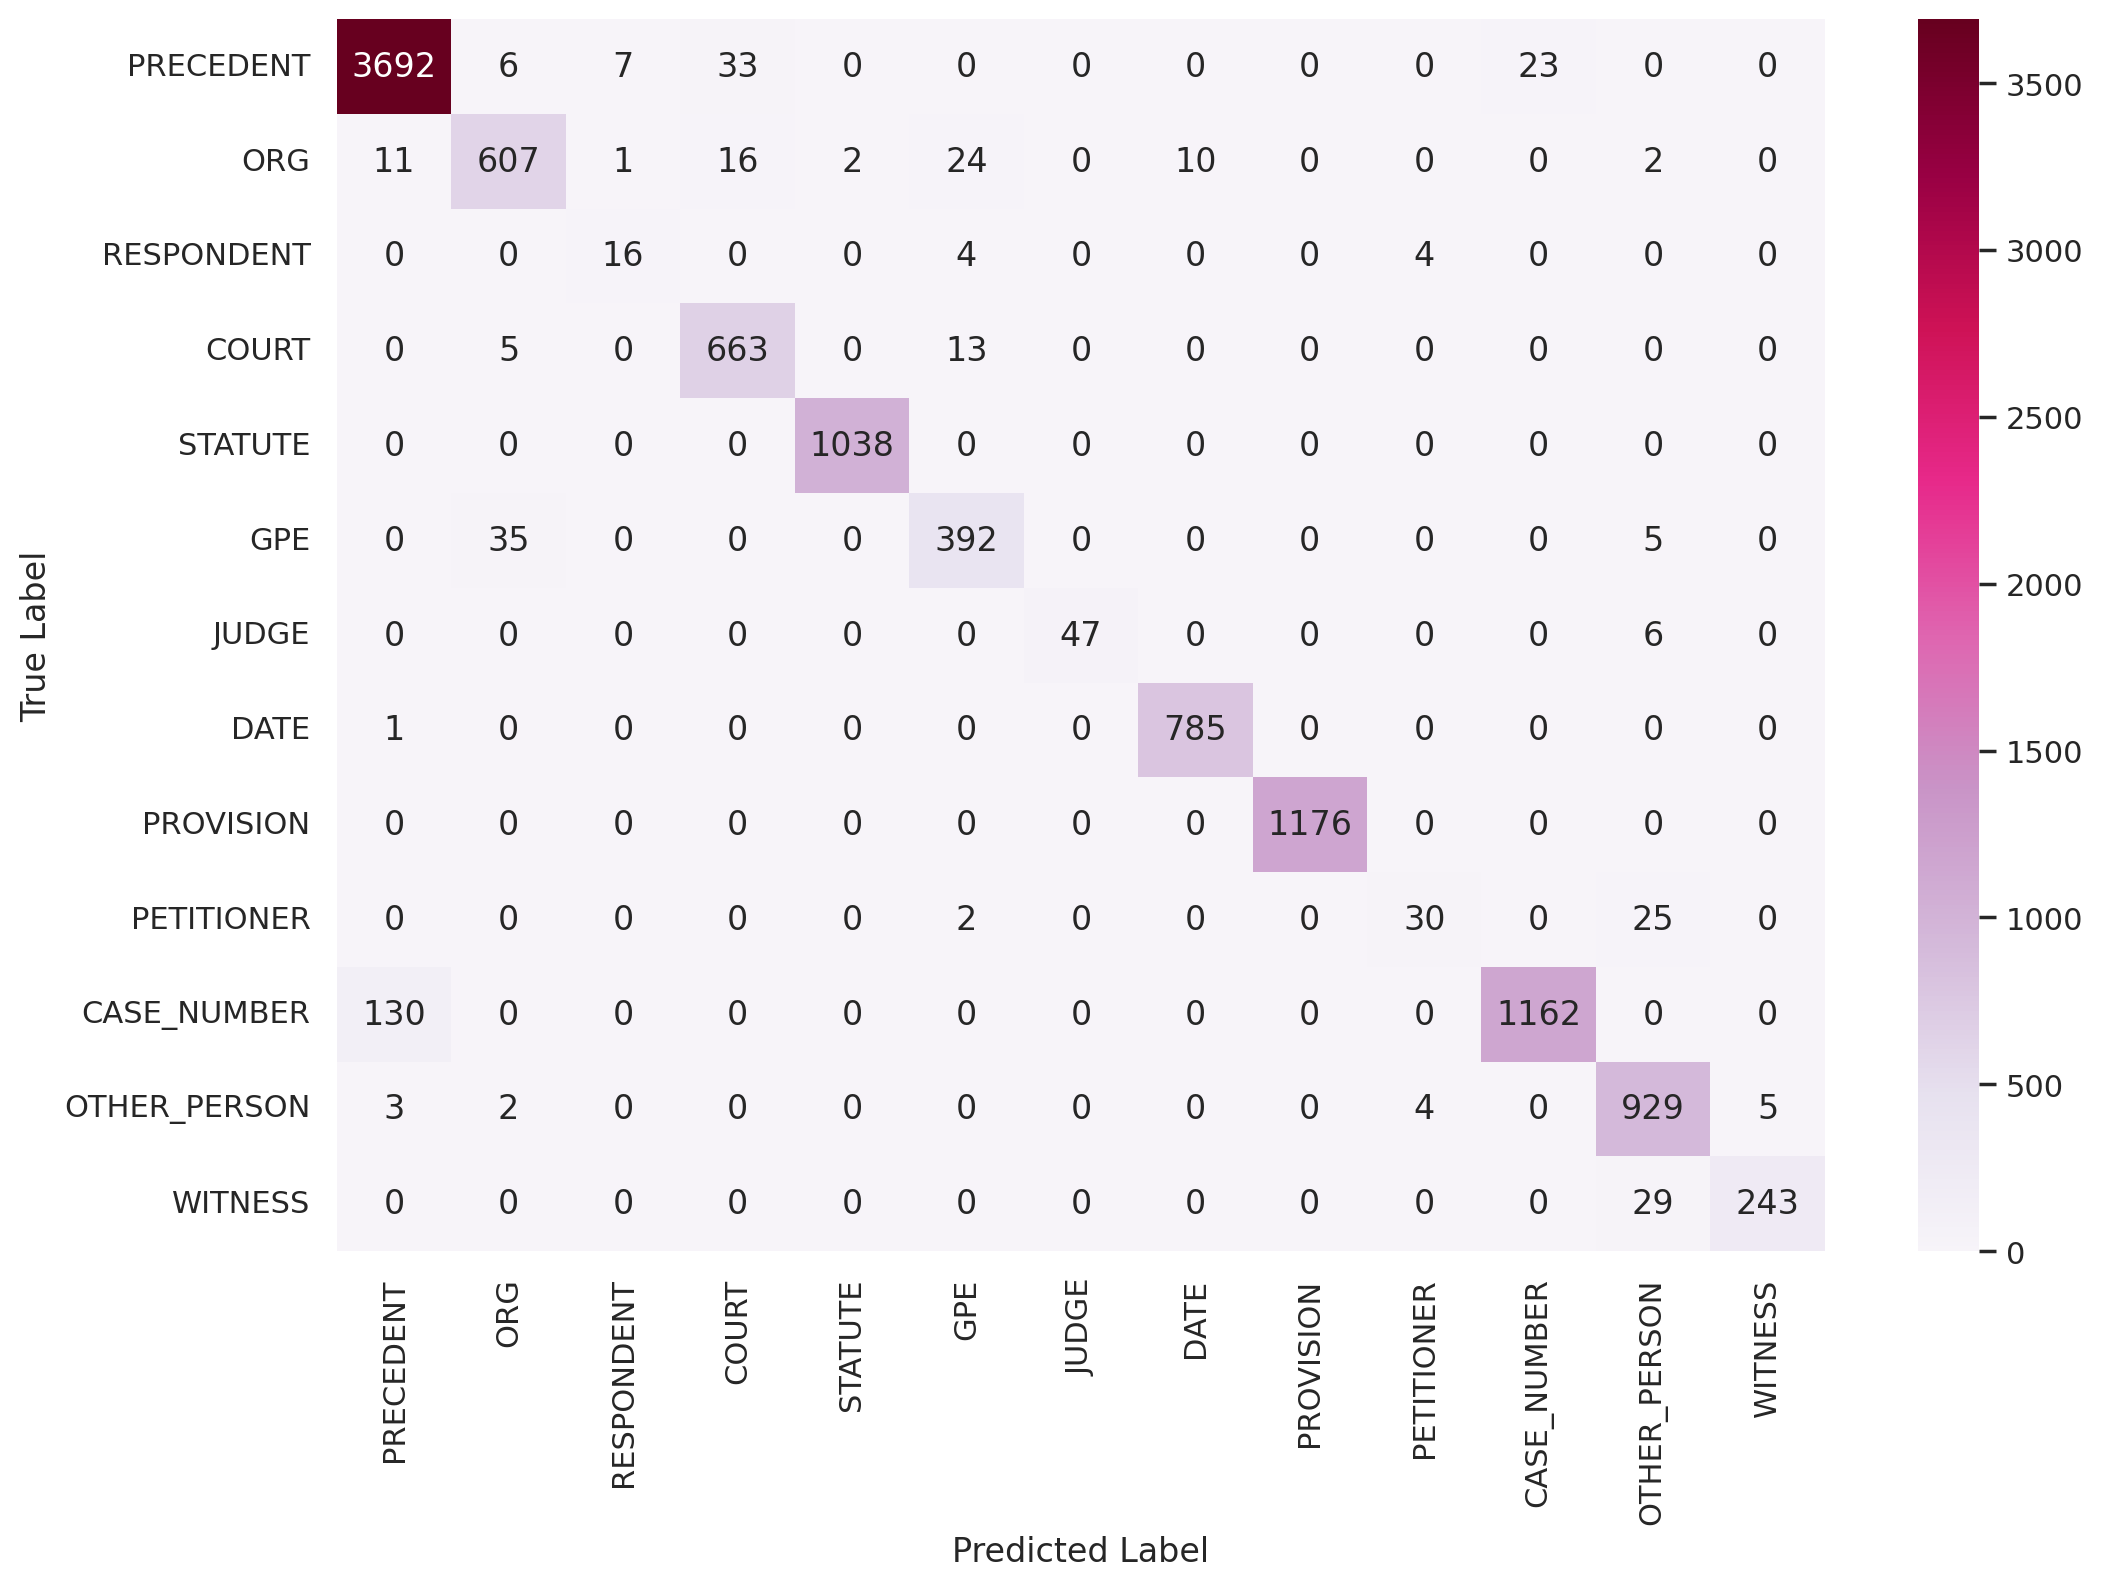

In [ ]:
generate_confusion_matrix(ensembler, val_dataloader, use_crf=False)